In [1]:
import kalepy as kale
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
from IPython.core.display import display
from multiprocess import Pool
from types import SimpleNamespace

import src.initial as initial
import src.mcmc as mcmc
import src.target as target
import src.utils as utils
from src.proposals import norm

utils.configure_pd(pd)
utils.configure_plt(plt)

In [2]:
%%time

mode_pairs_grid = [('full_max_indep','na'),
                   ('full_max_refl','na'),
                   ('max_indep','same_u'),
                   ('max_refl','same_u'),
                   ('max_indep','cond_same_u'),
                   ('max_refl','cond_same_u')]

# For the paper n_rep=10000. This takes about an hour running on 6 cores.
# We iterate until meeting occurs, so n_iter = max iters to run each chain for
pl = utils.add_iter([{'n_rep':10000, 'n_iter':1000000,
                      'prop_mode':prop_mode, 'ar_mode':ar_mode,
                      'sigma2':3, 'offset':3, 'd':1,}
                     for (prop_mode, ar_mode) in mode_pairs_grid])

def f(par):
    n = SimpleNamespace(**par)
    pr = f' - offset={n.offset}, sigma2 = {n.sigma2}, prop_mode = {n.prop_mode} ({n.i+1}/{n.i_total})'

    init = initial.Initialize(mode='target_indep')
    prop = norm.NormalProposalOffset(d=1, prop_mode=n.prop_mode, sigma2=n.sigma2, offset=n.offset)
    targ = target.ExpoTarget()
    cmh = mcmc.CoupledMH(init, prop, targ, ar_mode=n.ar_mode, break_condition='meet',
                         record_items=('accrej', 'chain_positions'))
    cmh.run(n_iter=n.n_iter, n_rep=n.n_rep, verbose=True, pr_postfix=pr)

    df0 = cmh.return_df()
    df0['mode'] = f'{n.prop_mode} {n.ar_mode}'
    return df0

df_list = []
with Pool(os.cpu_count()-2) as p:
    df_list += p.map(f, pl)

df = pd.concat(df_list)


1000 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
1000 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
1000 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
1000 - offset=3, sigma2 = 3, prop_mode = max_indep (3/6)
2000 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
2000 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
2000 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
3000 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
2000 - offset=3, sigma2 = 3, prop_mode = max_indep (3/6)
1000 - offset=3, sigma2 = 3, prop_mode = max_refl (6/6)
3000 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
1000 - offset=3, sigma2 = 3, prop_mode = max_indep (5/6)
3000 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
4000 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
4000 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
3000 - offset=3, sigma2 = 3, prop_mode = max_indep (3/6)
5000 - offset=3, sigma2 = 3, prop_mode = full_max_indep 

In [ ]:
# Process output
df_t = df.groupby(['rep_id','mode'])['t'].max().reset_index()
df_gp = df_t.groupby(['mode'])[['t']]
df_avg = df_gp.mean()
df_avg['se'] = df_gp.sem()
df_avg.reset_index(inplace=True)

In [10]:
#df_t.to_hdf('df_t_fig6.h5','df_t')

In [11]:
# Produce Table 2
mode_pairs = [
    ('max_indep same_u', r'$\bar{P}_{SQ}$ with $\bar{Q}_{MI}$'),
    ('max_refl same_u', r'$\bar{P}_{SQ}$ with $\bar{Q}_{MR}$'),
    ('full_max_indep na', r'$\bar{P}_{MI}$'),
    ('full_max_refl na', r'$\bar{P}_{MR}$'),
    ('max_indep cond_same_u', r'$\bar{P}_C$ with $\bar{Q}_{MI}$'),
    ('max_refl cond_same_u', r'$\bar{P}_C$ with $\bar{Q}_{MR}$')
]

mode_disp = [m[0] for m in mode_pairs]
mode_labs = [m[1] for m in mode_pairs]

df_out = df_avg.copy()
df_out = df_out.set_index('mode').loc[mode_disp,['t','se']]
df_out.reset_index(inplace=True)
df_out['mode'] = mode_labs

display(df_out)

print(df_out.to_latex(header=['Coupling','Avg. Meeting Time','S.E.'],
                      formatters={'t':'{:0.1f}'.format, 'se':'{:0.2f}'.format},
                      column_format='lcc', escape=False, index=False))

,mode,t,se
0,$\bar{P}_{SQ}$ with $\bar{Q}_{MI}$,74.404,1.000
1,$\bar{P}_{SQ}$ with $\bar{Q}_{MR}$,73.047,0.946
2,$\bar{P}_{MI}$,60.800,0.866
3,$\bar{P}_{MR}$,60.480,0.892
4,$\bar{P}_C$ with $\bar{Q}_{MI}$,60.625,0.879
5,$\bar{P}_C$ with $\bar{Q}_{MR}$,61.713,0.872


\begin{tabular}{lcc}
\toprule
                          Coupling & Avg. Meeting Time & S.E. \\
\midrule
$\bar{P}_{SQ}$ with $\bar{Q}_{MI}$ &              74.4 & 1.00 \\
$\bar{P}_{SQ}$ with $\bar{Q}_{MR}$ &              73.0 & 0.95 \\
                    $\bar{P}_{MI}$ &              60.8 & 0.87 \\
                    $\bar{P}_{MR}$ &              60.5 & 0.89 \\
   $\bar{P}_C$ with $\bar{Q}_{MI}$ &              60.6 & 0.88 \\
   $\bar{P}_C$ with $\bar{Q}_{MR}$ &              61.7 & 0.87 \\
\bottomrule
\end{tabular}



In [15]:
# Compute meeting time densities
t_max = 300 #df_t.t.max()
t_grid = np.linspace(0, t_max, 1000, dtype=int)

pdf_dict = dict()
for mode in mode_disp:
    mask = df_t['mode'] == mode
    dat = df_t.loc[mask, 't']
    kde = kale.KDE(dat)
    pdf = kde.pdf(t_grid, reflect=[-1, np.inf])
    pdf_dict[mode] = pdf

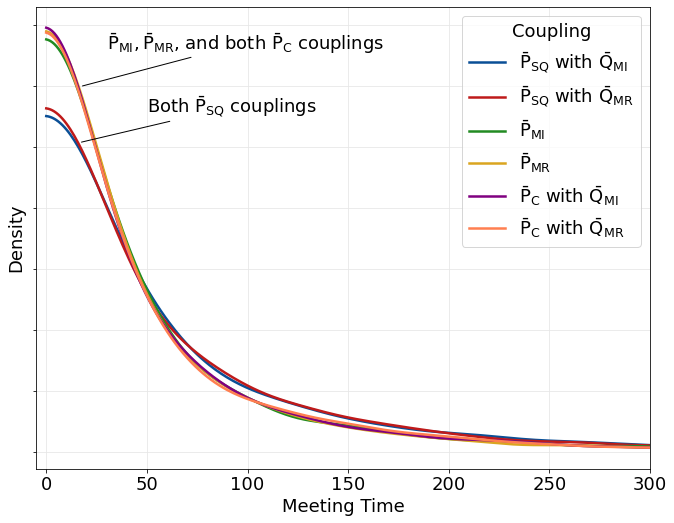

In [92]:
# Produce Figure 6: density plot of meeting time as a function of coupling

for mode, lab in zip(mode_disp, mode_labs):
    pdf = pdf_dict[mode]
    plt.plot(t_grid, pdf[1], label=lab)

plt.annotate(r'$\bar{P}_{MI}, \bar{P}_{MR}$, and both $\bar{P}_C$ couplings',
             xy=(18,.015), xytext=(30,.0165),
             arrowprops={'arrowstyle':'-','shrinkA':0, 'shrinkB':0})

plt.annotate(r'Both $\bar{P}_{SQ}$ couplings',
             xy=(17.5,.0127), xytext=(50,.0139),
             arrowprops={'arrowstyle':'-','shrinkA':0, 'shrinkB':0})

plt.xlabel('Meeting Time')
plt.ylabel('Density')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.NullFormatter())
plt.xlim(xmin=-5, xmax=t_max)
plt.legend(ncol=1, title='Coupling')

#plt.savefig('meettimedensity_labels.pdf')

plt.show()